In [1]:
import numpy as np

与分类树相比，回归树需要注意以下问题：

**回归树的划分：**虽然与分类树不同，分类树的标签是离散变量，而回归树的标签是连续变量。但是回归树与分类树的划分都是为了分类出与y相近的同一类人

    怎样对输入空间进行划分？——分类树与回归树相比，仅仅是标签变了，输入空间（x）未变，所以切分点的产生、特征的处理不变。
    叶子节点的计算：分类树属于多数原则选出叶子所属的分类作为预测值，回归树算出本叶子节点的平均值作为预测值
    怎样判断此次划分的合理性？——分类树对离散型标签采用最大增益（gini/information entropy）的方法进行特征选择， 而回归树使用平方误差最小准则进行特征选择。
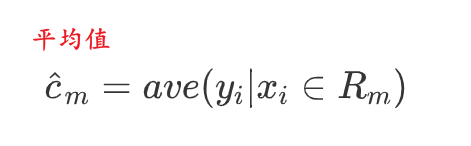


    

具体的划分策略：

对于所有的特征变量：

寻找特征变量的最优切分点，这个切分点会把数据集划分为两个子集，我们的目的是寻找那个能使两个子集标签平方误差之和最小的切分点。找到特征变量的最优切分点之后，再遍历特征变量，同样根据平方误差之和最小的准则，找到最优特征变量。

In [ ]:
# 当前样本X,y,weight,node_indices
"""
:param X : 所有样本
:param y : 所有样本对应的标签
:param weight : 所有样本对应的权重
:param node_indices : 当前样本对应的索引
:param is_linear : 所有特征的属性是连续型还是离散型

"""
n_samples, n_features = len(node_indices), X.shape[1]

## 寻找最佳特征
# 初始化
best_feature_variance_gain = -1
best_feature = None
best_feature_sets = None
for feature_i in range(n_features):
    
    ## 找出未缺失的样本
    nonan_indices = [i if ~np.isnan(X[i, feature_i]) for i in node_indices]
    # 找出缺失样本
    nan_indices = [i if np.isnan(X[i, feature_i]) for i in node_indices]
    # 未划分前的平方距离:使用该属性上无缺失的样本来计算
    cur_variance = variance(y[nonan_indices], weight[nonan_indices])
    # 无缺失值样本所占的比例:对每一个样本赋予了权重后,利用权重计算无缺失样本所占的比例
    lou = np.sum(weight[nonan_indices]) / np.sum(weight[node_indices])
    
    ## 基于无缺失的样本来寻找特征的最佳切分点
    # 当前特征i的所有候选分割点
    split_points, split_func = create_split_points(X[nonan_indices], feature_i, is_linear=False)
    
    ## 产生最佳切分点
    # 初始化
    best_variance_gain = -1# 存储本特征的最佳切分点对应的gini_gain
    best_sets = None# 存储最佳切分点切分的左右分支
    # 依次使用候选分割点对当前集合（X，y）进行二分分割
    for point in split_points:
        # 使用每个候选分割点进行二分分割
        left_indices = [i for i in nonan_indices if split_func(X[i], point)]
        right_indices = [i for i in nonan_indices if not split_func(X[i], point)]
        # 分好左右分支后计算划分后的variance_gain
        # 左右分支的权重计算不再使用频数
        w_left, w_right = np.sum(weight[left_indices])/np.sum(weight), np.sum(weight[right_indices])/np.sum(weight)
        cur_variance_gain = cur_variance - (w_left*variance(y[left_indices],weight[left_indices]) + w_right*variance(y[right_indices], weight[right_indices]))
        # 选择最佳的split point
        if cur_variance_gain >= best_variance_gain:
            best_variance_gain = cur_variance_gain
            best_sets = {
                "best_split_point":point,
                "left_indices": left_indices,
                "right_indices": right_indices,
            }
    
    ## 基于上述方法计算所有特征的加权gini_gain,找到最佳特征
    # 找到特征i的最佳gini_point后,使用权重计算最终的gini_gain
    cur_feature_gini_gain = lou * best_gini_gain
    
    if cur_feature_variance_gain >= best_featur_variance_gain:
    best_feature_variance_gain = cur_feature_variance_gain
    best_feature = feature_i
    best_feature_sets = best_sets
    # 找到最佳特征
    

模块化

计算平方误差

In [ ]:
def variance(y, weight):
    """
    :param y : 当前节点样本的连续标签
    :param weight : 当前节点样本的权重
    :return square_variance : 平方误差和
    
    """
    mean_y = np.mean(y, axis=0)
    sum_square_variance = np.sum(np.square(y-mean_y)*weight)
    return sum_square_variance

In [ ]:
y = [14,30,18,11]
weight = np.ones(len(y))
variance(y, weight)

In [ ]:
y = [22,26]
weight = np.ones(len(y))
variance(y, weight)

产生候选切分点-与之前相同

In [ ]:
 def create_split_points(X, feature_i, is_linear=False):
    
        """
        根据特征i是连续型/离散型特征得到特征i的所有候选分割点,并返回对应的分割函数
        :param X: 当前集合的样本（无缺失值）
        :param feature_i : 给定的特征索引
        :return 特征i的所有候选分割点、分割函数

        """

        # 1、确定特征i的所有可能取值
        feature_values = np.unique(X[:, feature_i])# 已排序的 

        # 2、根据特征i是连续型/离散型特征对这些可能取值进行处理从而得到特征i的所有候选分割点；    
        split_points = None
        split_func = None

        if is_linear:
            split_points = (feature_values[1:] + feature_values[:-1]) / 2 # 特征是连续型特征则使用二分法找到所有的切分点
            split_func = lambda x,split_point : x[feature_i] >= split_point

        else:
            split_points = feature_values# 离散型特征直接使用特征的各个取值作为切分点
            split_func = lambda x,split_point : x[feature_i] == split_point
        return split_points, split_func

In [ ]:
x = np.arange(1,11,1).reshape(-1,1)
y = np.array([5.56, 5.7, 5.91, 6.4, 6.8, 7.05, 8.9, 8.7, 9, 9.05])
create_split_points(x, 0, is_linear=True)

In [ ]:
# 贷款数据集
X = np.array([[10, 15], [11, 40], [12, 20], [9, 30], [13, 10], [8, 25]])
y = np.array([14, 30, 18, 26, 11, 22])
create_split_points(X,0,is_linear=True)

In [ ]:
def get_best_split_point(X,y,node_indices, weight, feature_i, is_linear=False):

    """
    对于当前节点集合（X，y）-node_indices计算特征i的基尼增益
    :param X: 所有样本
    :param y: 所有标签
    :param node_indices : 当前样本集合对应的索引(无缺失值)
    :param weight: 所有样本的权重
    :param is_linear : 特征的类型
    :return : 返回特征i的基尼增益以及分割的左右子树

    """
    ## 基于无缺失的样本来寻找特征的最佳切分点
    # 当前特征i的所有候选分割点
    split_points, split_func = create_split_points(X[node_indices], feature_i, is_linear)
    
    ## 产生最佳切分点
    # 初始化
    best_variance_gain = -1# 存储本特征的最佳切分点对应的gini_gain
    best_sets = None# 存储最佳切分点切分的左右分支
    # 依次使用候选分割点对当前集合（X，y）进行二分分割
    for point in split_points:
        # 使用每个候选分割点进行二分分割
        left_indices = [i for i in node_indices if split_func(X[i],point)]
        right_indices = [i for i in node_indices if not split_func(X[i], point)]
        ## 分好左右分支后计算划分后的variance_gain
        # 左右分支的权重计算不再使用频数
        w_left, w_right = np.sum(weight[left_indices])/np.sum(weight), np.sum(weight[right_indices])/np.sum(weight)
        
        # 未划分前的平方误差和:使用该属性上无缺失的样本来计算
        cur_variance = variance(y[node_indices],    weight[node_indices])
        # 未划分前-划分后(左右)==variance_gain
        cur_variance_gain = cur_variance - (w_left*variance(y[left_indices],weight[left_indices]) + w_right*variance(y[right_indices], weight[right_indices]))
        
        # 选择最佳的split point
        if cur_variance_gain >= best_variance_gain:
            best_variance_gain = cur_variance_gain
            # 划分时传给左右子集的weight、indices均不同weigh
            # weight在之后再重置
            best_sets = {
                "best_split_point":point,
                "left_indices": left_indices,
                "right_indices": right_indices,
            }
    return best_variance_gain, best_sets

In [ ]:
X = np.arange(1,11,1).reshape(-1,1)
y = np.array([5.56, 5.7, 5.91, 6.4, 6.8, 7.05, 8.9, 8.7, 9, 9.05])
weight = np.ones(len(X))
get_best_split_point(X,y,range(len(x)), weight, 0, is_linear=True)

In [ ]:
# 贷款数据集
X = np.array([[10, 15], [11, 40], [12, 20], [9, 30], [13, 10], [8, 25]])
y = np.array([14, 30, 18, 26, 11, 22])
weight = np.ones(len(X))
get_best_split_point(X,y,range(len(X)), weight, 0, is_linear=True)

In [ ]:
def get_best_split_feature(X,y,node_indices,weight, is_linear):
        """
        对于当前节点集合（X，y）-node_indices,找到最佳特征：求所有特征的gini_gain
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引
        :param is_linear : 特征的类型

        """

        # 获取样本数和特征数
        n_samples, n_features = len(node_indices), X.shape[1]
        
        # 初始化
        best_variance_gain = -1
        best_feature = None
        best_sets = None
        
        # 依次求所有特征的gini_gain
        for feature_i in range(n_features):
            # 特征在所有样本中取值唯一时无需找split_point和参与特征划分
            if len(np.unique(X[node_indices][:,feature_i])) == 1:
                continue
                
            ## 找出未缺失的样本
            nonan_indices = [i  for i in node_indices if ~np.isnan(X[i, feature_i])]
            # 找出缺失样本
            nan_indices = [i  for i in node_indices if np.isnan(X[i, feature_i])]
            # 无缺失值样本所占的比例:对每一个样本赋予了权重后,利用权重计算无缺失样本所占的比例
            lou = np.sum(weight[nonan_indices]) / np.sum(weight[node_indices])
            
            # 特征i的基尼增益以及分割的左右子树
            cur_variance_gain,cur_branch_sets = get_best_split_point(X,y,nonan_indices, weight,feature_i, is_linear)
            # 找到特征i的最佳gini_point后,使用权重计算最终的gini_gain
            cur_variance_gain = lou * cur_variance_gain
            
            # 寻找最佳特征
            if cur_variance_gain >= best_variance_gain:
                best_variance_gain = cur_variance_gain
                best_feature = feature_i
                best_sets = cur_branch_sets
                # 修改权重
                left_weight, right_weight = np.zeros_like(weight),np.zeros_like(weight)
                left_indices, right_indices = best_sets["left_indices"],best_sets["right_indices"]
                left_weight[left_indices], right_weight[right_indices] = weight[left_indices], weight[right_indices]
                left_weight[nan_indices], right_weight[nan_indices] = np.sum(weight[left_indices]) / np.sum(weight[nonan_indices]),np.sum(weight[right_indices]) / np.sum(weight[nonan_indices])

                # 将缺失样本按不同的比重放到左右两个子集中
                left_indices.extend(nan_indices)
                right_indices.extend(nan_indices)
                best_sets["left_indices"] = left_indices
                best_sets["right_indices"] = right_indices
                best_sets["left_weight"] = left_weight
                best_sets["right_weight"] = right_weight

        # 找到了当前节点所用的最佳特征（也找到了该特征的最佳分割点）
        
        return best_feature,best_variance_gain, best_sets

In [ ]:
X = np.arange(1,11,1).reshape(-1,1)
y = np.array([5.56, 5.7, 5.91, 6.4, 6.8, 7.05, 8.9, 8.7, 9, 9.05])
weight = np.ones(len(X))
get_best_split_feature(X,y,range(len(X)),weight, is_linear=True)

In [ ]:
# 贷款数据集
X = np.array([[10, 15], [11, 40], [12, 20], [9, 30], [13, 10], [8, 25]])
y = np.array([14, 30, 18, 26, 11, 22])
weight = np.ones(len(X))
get_best_split_feature(X,y,range(len(X)), weight,is_linear=True)

叶节点的处理：不再按照多数原则，而是计算均值

In [ ]:
def leaf_value(y):
    return np.mean(y, axis=0)

修改后的代码(含预剪枝，未包含后剪枝)

In [26]:
class Node(object):
    """通过树结点的各属性记录生成的树结构"""
    def __init__(self,
                 best_feature_i=None, 
                 best_split_point=None,
                 left_node=None, 
                 right_node=None,
                 leaf_value = None,
                 is_leaf=False,
                 variance=None):
        """
        每个当前结点Node都记录了当前的划分状况
        :param left_child_node : 结点的左侧子结点
        :param right_child_node : 结点的右侧子结点
        :param best_feature_i : 当前结点的最佳划分特征
        :param split_point : 当前结点的最佳特征对应的最佳分割点
        :param leaf_class : 记录当前节点所属的类别
        :param is_leaf : 只有在is_leaf==True时，leaf_class才生效
        :param gini : 当前节点的gini_index
        
        """
        self.best_feature_i = best_feature_i
        self.best_split_point = best_split_point
        self.left_node = left_node
        self.right_node = right_node
        self.leaf_value = leaf_value
        self.is_leaf = is_leaf
        self.variance = variance
        
class CartRegressionTree():
    """使用cart算法构建决策树"""
    
    def __init__(self, max_depth = float("inf"),min_sample_split=2, min_variance_decrease=None):
        # 代表决策树的决策树根节点
        self.root_node = None 
        # 预设的决策树最大深度
        self.max_depth = max_depth
        # 预设的决策树叶子节点最小样本数
        self.min_sample_split = min_sample_split
        # 预设的基尼系数增益的最小值（variance_gain太小时不划分）
        self.min_variance_decrease = min_variance_decrease
        
    def fit(self, X,y,is_linear=False):
        """
        决策树拟合
        :param X : 训练数据集∈（m,n）
        :param y : 训练标签∈（n,1）
        :param is_linear : 特征是否为连续型
        
        """
        # 创建决策树根结点
        self.root_node = Node()
        # 默认根节点的深度为1
        cur_depth = 1
        # 根节点的初始化权重
        # 样本的初始权重:都为1
        weight = np.ones((len(X))) # 全局的weight:初始化为全1 
        # 递归构建决策树
        self._build_tree_recussive(X,y,np.arange(len(X)),weight,self.root_node, cur_depth, is_linear)
    
    def _build_tree_recussive(self, X,y, node_indices,weight,node:Node, cur_depth, is_linear):
        """
        对于当前节点集合（X，y）-node_indices,递归建立决策树
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引
        :param weight : 所有样本对应的权重
        :param node : 当前结点的状态记录

        """
        n_samples = len(node_indices)
        n_features = X.shape[1]
        # 记录本节点的状态
        node.variance = self._variance(y[node_indices], weight[node_indices])
        node.leaf_value = self._leaf_value(y[node_indices])

        ## 递归基
        # 节点包含数据全为同一个值，此时无需划分
        if len(np.unique(y[node_indices])) <= 1:
            # 记录叶子结点所属的分类
            node.is_leaf = True
            return
        # 没有更多特征(当前节点所含样本所有特征都只有一个取值)
        if np.sum([len(np.unique(X[node_indices][:,i])) for i in range(n_features)]) == n_features:
            node.is_leaf = True
            return
        # 限制构建子树的深度
        if cur_depth >= self.max_depth:
            node.is_leaf = True
            return
        # 限制节点的最小样本量
        if n_samples < self.min_sample_split:
            node.is_leaf = True
            return

        ## 处理当前节点自身
        # 找到最佳特征和特征的最佳分割点
        best_feature_i,best_variance_gain, best_sets = self._get_best_split_feature(X, y, node_indices, weight, is_linear)
        
        # 基尼系数增益的最小值（gini_gain太小时不划分）
        if self.min_variance_decrease is not None and  best_variance_gain < self.min_variance_decrease:
            node.is_leaf = True
            return
        
        # 基于最佳特征和最佳分割点分成左右子树left,right
        left_indices = best_sets["left_indices"]
        right_indices = best_sets["right_indices"]
        left_weight = best_sets["left_weight"]
        right_weight = best_sets["right_weight"]
        # 记录本节点的状态
        node.best_feature_i = best_feature_i
        node.best_split_point = best_sets["best_split_point"]
        node.left_node = Node()
        node.right_node = Node()
        # --leaf_class和gini在递归基时记录

        # 让buildtree()帮忙划分左右子树
        self._build_tree_recussive(X,y,left_indices,left_weight, node.left_node, cur_depth+1, is_linear)
        self._build_tree_recussive(X,y,right_indices,right_weight, node.right_node, cur_depth+1, is_linear)
                                   
    def _get_best_split_feature(self, X,y,node_indices,weight, is_linear):
        """
        对于当前节点集合（X，y）-node_indices,找到最佳特征：求所有特征的gini_gain
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引
        :param is_linear : 特征的类型

        """

        # 获取样本数和特征数
        n_samples, n_features = len(node_indices), X.shape[1]
        
        # 初始化
        best_variance_gain = -1
        best_feature = None
        best_sets = None
        
        # 依次求所有特征的gini_gain
        for feature_i in range(n_features):
            # 特征在所有样本中取值唯一时无需找split_point和参与特征划分
            if len(np.unique(X[node_indices][:,feature_i])) == 1:
                continue
                
            ## 找出未缺失的样本
            nonan_indices = [i  for i in node_indices if ~np.isnan(X[i, feature_i])]
            # 找出缺失样本
            nan_indices = [i  for i in node_indices if np.isnan(X[i, feature_i])]
            # 无缺失值样本所占的比例:对每一个样本赋予了权重后,利用权重计算无缺失样本所占的比例
            lou = np.sum(weight[nonan_indices]) / np.sum(weight[node_indices])
            
            # 特征i的基尼增益以及分割的左右子树
            cur_variance_gain,cur_branch_sets = self._get_best_split_point(X,y,nonan_indices, weight,feature_i, is_linear)
            # 找到特征i的最佳gini_point后,使用权重计算最终的gini_gain
            cur_variance_gain = lou * cur_variance_gain
            
            # 寻找最佳特征
            if cur_variance_gain >= best_variance_gain:
                best_variance_gain = cur_variance_gain
                best_feature = feature_i
                best_sets = cur_branch_sets
                # 修改权重
                left_weight, right_weight = np.zeros_like(weight),np.zeros_like(weight)
                left_indices, right_indices = best_sets["left_indices"],best_sets["right_indices"]
                left_weight[left_indices], right_weight[right_indices] = weight[left_indices], weight[right_indices]
                left_weight[nan_indices], right_weight[nan_indices] = np.sum(weight[left_indices]) / np.sum(weight[nonan_indices]),np.sum(weight[right_indices]) / np.sum(weight[nonan_indices])

                # 将缺失样本按不同的比重放到左右两个子集中
                left_indices.extend(nan_indices)
                right_indices.extend(nan_indices)
                best_sets["left_indices"] = left_indices
                best_sets["right_indices"] = right_indices
                best_sets["left_weight"] = left_weight
                best_sets["right_weight"] = right_weight

        # 找到了当前节点所用的最佳特征（也找到了该特征的最佳分割点）
        
        return best_feature,best_variance_gain, best_sets
    
    def _get_best_split_point(self, X,y,node_indices, weight, feature_i, is_linear=False):

        """
        对于当前节点集合（X，y）-node_indices计算特征i的基尼增益
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引(无缺失值)
        :param weight: 所有样本的权重
        :param is_linear : 特征的类型
        :return : 返回特征i的基尼增益以及分割的左右子树

        """
        ## 基于无缺失的样本来寻找特征的最佳切分点
        # 当前特征i的所有候选分割点
        split_points, split_func = self._create_split_points(X[node_indices], feature_i, is_linear)

        ## 产生最佳切分点
        # 初始化
        best_variance_gain = -1# 存储本特征的最佳切分点对应的gini_gain
        best_sets = None# 存储最佳切分点切分的左右分支
        # 依次使用候选分割点对当前集合（X，y）进行二分分割
        for point in split_points:
            # 使用每个候选分割点进行二分分割
            left_indices = [i for i in node_indices if split_func(X[i],point)]
            right_indices = [i for i in node_indices if not split_func(X[i], point)]
            ## 分好左右分支后计算划分后的variance_gain
            # 左右分支的权重计算不再使用频数
            w_left, w_right = np.sum(weight[left_indices])/np.sum(weight), np.sum(weight[right_indices])/np.sum(weight)

            # 未划分前的平方误差和:使用该属性上无缺失的样本来计算
            cur_variance = self._variance(y[node_indices],weight[node_indices])
            # 未划分前-划分后(左右)==variance_gain
            cur_variance_gain = cur_variance - (w_left*self._variance(y[left_indices],weight[left_indices]) + w_right*self._variance(y[right_indices], weight[right_indices]))

            # 选择最佳的split point
            if cur_variance_gain >= best_variance_gain:
                best_variance_gain = cur_variance_gain
                # 划分时传给左右子集的weight、indices均不同weigh
                # weight在之后再重置
                best_sets = {
                    "best_split_point":point,
                    "left_indices": left_indices,
                    "right_indices": right_indices,
                }
        return best_variance_gain, best_sets
    
    def _create_split_points(self, X, feature_i, is_linear=False):
    
        """
        根据特征i是连续型/离散型特征得到特征i的所有候选分割点,并返回对应的分割函数
        :param X: 当前集合的样本（无缺失值）
        :param feature_i : 给定的特征索引
        :return 特征i的所有候选分割点、分割函数

        """

        # 1、确定特征i的所有可能取值
        feature_values = np.unique(X[:, feature_i])# 已排序的 

        # 2、根据特征i是连续型/离散型特征对这些可能取值进行处理从而得到特征i的所有候选分割点；    
        split_points = None
        split_func = None

        if is_linear:
            split_points = (feature_values[1:] + feature_values[:-1]) / 2 # 特征是连续型特征则使用二分法找到所有的切分点
            split_func = lambda x,split_point : x[feature_i] >= split_point

        else:
            split_points = feature_values# 离散型特征直接使用特征的各个取值作为切分点
            split_func = lambda x,split_point : x[feature_i] == split_point
        return split_points, split_func
    
     
    
    def _variance(self, y, weight):
        """
        :param y : 当前节点样本的连续标签
        :param weight : 当前节点样本的权重
        :return square_variance : 平方误差和

        """
        mean_y = np.mean(y, axis=0)
        sum_square_variance = np.sum(np.square(y-mean_y)*weight)
        return sum_square_variance

    def _leaf_value(self, y):
        return np.mean(y, axis=0)
    
   
    
    def predict(self,X,is_linear=False):
        """
        :param X: 待预测的m个样本

        """
        # 每一个样本都通过二叉搜索决策树树查找所属类别,决策树由其根节点作为代表
        y_pred = [self._search_yhat(x, self.root_node, is_linear) for x in X]
        return y_pred

    def _search_yhat(self, x, node:Node, is_linear=False):
        """
        : param x: 待预测所属分类的样本
        : param node : 当前所在节点

        """
        # 递归基
        if node.is_leaf:# 已经走到叶子
            return node.leaf_value
        ## 当前节点的工作
        # 本样本最终要往哪个分支走
        goto = None
        # 根据当前节点的最佳特征及最佳切分点决定x是继续往左边走还是往右边走
        feature_value = x[node.best_feature_i]
        # 离散型/连续型特征处理不同
        if is_linear:
            if feature_value >= node.best_split_point:
                goto = node.left_node# 往左边
            else:
                goto = node.right_node#往右边
        else:
            if feature_value == node.best_split_point:
                goto = node.left_node# 往左边
            else:
                goto = node.right_node
        return self._search_yhat(x, goto, is_linear)
        
    


In [22]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y=True)
X_train, test_X, y_train, test_y = train_test_split(X,y, test_size=0.3)


D:\yangdaopy\Pycharm\pythondownload\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

In [33]:
from sklearn.metrics import accuracy_score, mean_squared_error
model = CartRegressionTree()
model.fit(X_train, y_train, is_linear=True)
y_pred = model.predict(test_X, is_linear=True)
mean_squared_error(test_y, y_pred)

29.42276315789474

In [34]:
print(y_pred)

[31.5, 18.9, 27.5, 6.3, 34.9, 17.5, 17.3, 13.1, 24.3, 48.3, 20.6, 36.1, 17.5, 24.3, 16.7, 24.6, 25.0, 13.5, 11.8, 20.0, 20.6, 12.0, 31.2, 23.6, 8.7, 19.6, 11.8, 20.0, 24.3, 17.0, 17.0, 22.9, 46.7, 16.1, 12.7, 17.1, 25.0, 17.9, 23.7, 48.3, 21.9, 17.9, 26.5, 44.8, 22.3, 19.1, 20.3, 36.2, 14.5, 22.5, 22.2, 29.6, 31.5, 21.8, 25.0, 37.9, 31.6, 16.6, 27.9, 41.7, 13.9, 22.7, 13.3, 24.8, 48.5, 29.6, 14.1, 30.1, 19.1, 19.7, 50.0, 31.5, 18.3, 18.2, 22.9, 37.0, 24.5, 44.8, 26.2, 17.9, 23.7, 22.8, 24.7, 19.3, 44.8, 5.0, 16.2, 10.5, 23.1, 26.4, 31.2, 16.5, 18.9, 21.0, 6.3, 23.7, 11.8, 20.5, 20.9, 22.7, 14.9, 6.3, 14.1, 16.3, 27.5, 50.0, 23.2, 31.1, 18.7, 17.6, 21.9, 22.5, 20.7, 20.0, 14.5, 16.3, 11.5, 18.4, 23.1, 13.5, 19.6, 23.6, 24.4, 18.0, 31.1, 16.2, 27.9, 15.3, 16.7, 28.7, 23.7, 25.0, 17.5, 19.5, 5.6, 24.2, 17.0, 29.6, 16.4, 17.3, 23.6, 18.9, 22.0, 16.2, 36.1, 26.4, 14.1, 14.6, 23.9, 20.5, 31.2, 16.1]


In [35]:
print(test_y)

[31.6 21.7 23.   8.5 32.9 19.4  7.  15.1 21.2 50.  29.8 33.2 16.6 41.3
 12.5 22.3 22.  13.4  9.5 10.9 11.9 17.2 30.8 23.9  7.5 23.  13.4 21.2
 27.  17.4 21.5 24.1 35.2 20.2 19.1 16.  23.3 13.8 23.7 21.9 16.8  7.
 22.1 42.8 21.2 19.6 21.4 23.6 13.5 20.7 20.2 50.  34.6 22.4 33.  36.2
 33.1 14.  20.8 37.6 10.2 19.6  8.3 23.  50.  34.9 13.8 26.6 10.2 20.
 38.7 31.7 19.6 23.4 22.2 33.1 26.6 50.  28.6 13.8 22.5 18.5 21.7 21.7
 50.  10.2 20.3  5.  22.2 23.4 29.1  8.1 17.4 18.6  8.8 30.1 13.4 18.6
 20.3 19.4 14.1  7.2 14.9  7.2 15.4 50.  20.1 28.  17.8 17.2 19.9 21.1
 28.7 20.8 11.7 12.1 10.9 16.1 20.6 17.8 19.8 37.2 21.6 18.4 24.1 24.
 35.1 23.8 11.7 26.7 23.5 27.5 20.  27.1 10.5 23.1 19.4 33.4 14.3 15.7
 28.7 18.8 17.7 24.3 33.4 22.6 19.1 11.8 22.2 19.8 30.5 21. ]


**后剪枝**

分类树对叶子处理的方式是使用多数原则预测分类，预测误差使用gini，而回归树对叶子的处理方式是求均值，预测误差使用平方误差，所以根据公式，只用将求gini改为求平方误差variance

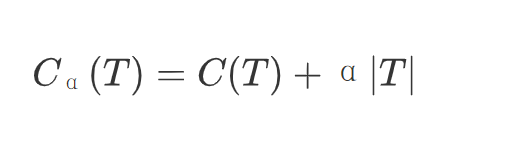

In [ ]:
def prune(self, alpha=0):
        """对决策树进行后剪枝"""
        return self._pruning_node(self.root_node, alpha)
        
def _pruning_node(self, node,alpha):
    """
    :param node : 当前处理的节点
    :param alpha: loss的参数，alpha≥0

    """
    ## 递归基:当前节点是叶子节点则直接返回
    if node.is_leaf:
        return 
    ## 让递归函数帮忙处理左右子树
    self._pruning_node(node.left_node, alpha)
    self._pruning_node(node.right_node, alpha)

    ## 处理当前节点
    # 剪枝后
    post_loss = node.variance + alpha * 1 
    # 剪枝前
    pre_loss = node.left_node.variance + node.right_node.variance + alpha * 2
    # 比较剪枝前的loss与剪枝后的loss
    if post_loss < pre_loss: # 剪枝后loss更小则剪枝（收回左右结点）
        node.left_node = None
        node.right_node = None
        node.best_feature_i = None
        node.best_split_point = None
        node.is_leaf = True

修改后的代码

In [37]:
class Node(object):
    """通过树结点的各属性记录生成的树结构"""
    def __init__(self,
                 best_feature_i=None, 
                 best_split_point=None,
                 left_node=None, 
                 right_node=None,
                 leaf_value = None,
                 is_leaf=False,
                 variance=None):
        """
        每个当前结点Node都记录了当前的划分状况
        :param left_child_node : 结点的左侧子结点
        :param right_child_node : 结点的右侧子结点
        :param best_feature_i : 当前结点的最佳划分特征
        :param split_point : 当前结点的最佳特征对应的最佳分割点
        :param leaf_class : 记录当前节点所属的类别
        :param is_leaf : 只有在is_leaf==True时，leaf_class才生效
        :param gini : 当前节点的gini_index
        
        """
        self.best_feature_i = best_feature_i
        self.best_split_point = best_split_point
        self.left_node = left_node
        self.right_node = right_node
        self.leaf_value = leaf_value
        self.is_leaf = is_leaf
        self.variance = variance
        
class CartRegressionTree():
    """使用cart算法构建决策树"""
    
    def __init__(self, max_depth = float("inf"),min_sample_split=2, min_variance_decrease=None):
        # 代表决策树的决策树根节点
        self.root_node = None 
        # 预设的决策树最大深度
        self.max_depth = max_depth
        # 预设的决策树叶子节点最小样本数
        self.min_sample_split = min_sample_split
        # 预设的基尼系数增益的最小值（variance_gain太小时不划分）
        self.min_variance_decrease = min_variance_decrease
        
    def fit(self, X,y,is_linear=False):
        """
        决策树拟合
        :param X : 训练数据集∈（m,n）
        :param y : 训练标签∈（n,1）
        :param is_linear : 特征是否为连续型
        
        """
        # 创建决策树根结点
        self.root_node = Node()
        # 默认根节点的深度为1
        cur_depth = 1
        # 根节点的初始化权重
        # 样本的初始权重:都为1
        weight = np.ones((len(X))) # 全局的weight:初始化为全1 
        # 递归构建决策树
        self._build_tree_recussive(X,y,np.arange(len(X)),weight,self.root_node, cur_depth, is_linear)
    
    def _build_tree_recussive(self, X,y, node_indices,weight,node:Node, cur_depth, is_linear):
        """
        对于当前节点集合（X，y）-node_indices,递归建立决策树
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引
        :param weight : 所有样本对应的权重
        :param node : 当前结点的状态记录

        """
        n_samples = len(node_indices)
        n_features = X.shape[1]
        # 记录本节点的状态
        node.variance = self._variance(y[node_indices], weight[node_indices])
        node.leaf_value = self._leaf_value(y[node_indices])

        ## 递归基
        # 节点包含数据全为同一个值，此时无需划分
        if len(np.unique(y[node_indices])) <= 1:
            # 记录叶子结点所属的分类
            node.is_leaf = True
            return
        # 没有更多特征(当前节点所含样本所有特征都只有一个取值)
        if np.sum([len(np.unique(X[node_indices][:,i])) for i in range(n_features)]) == n_features:
            node.is_leaf = True
            return
        # 限制构建子树的深度
        if cur_depth >= self.max_depth:
            node.is_leaf = True
            return
        # 限制节点的最小样本量
        if n_samples < self.min_sample_split:
            node.is_leaf = True
            return

        ## 处理当前节点自身
        # 找到最佳特征和特征的最佳分割点
        best_feature_i,best_variance_gain, best_sets = self._get_best_split_feature(X, y, node_indices, weight, is_linear)
        
        # 基尼系数增益的最小值（gini_gain太小时不划分）
        if self.min_variance_decrease is not None and  best_variance_gain < self.min_variance_decrease:
            node.is_leaf = True
            return
        
        # 基于最佳特征和最佳分割点分成左右子树left,right
        left_indices = best_sets["left_indices"]
        right_indices = best_sets["right_indices"]
        left_weight = best_sets["left_weight"]
        right_weight = best_sets["right_weight"]
        # 记录本节点的状态
        node.best_feature_i = best_feature_i
        node.best_split_point = best_sets["best_split_point"]
        node.left_node = Node()
        node.right_node = Node()
        # --leaf_class和gini在递归基时记录

        # 让buildtree()帮忙划分左右子树
        self._build_tree_recussive(X,y,left_indices,left_weight, node.left_node, cur_depth+1, is_linear)
        self._build_tree_recussive(X,y,right_indices,right_weight, node.right_node, cur_depth+1, is_linear)
                                   
    def _get_best_split_feature(self, X,y,node_indices,weight, is_linear):
        """
        对于当前节点集合（X，y）-node_indices,找到最佳特征：求所有特征的gini_gain
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引
        :param is_linear : 特征的类型

        """

        # 获取样本数和特征数
        n_samples, n_features = len(node_indices), X.shape[1]
        
        # 初始化
        best_variance_gain = -1
        best_feature = None
        best_sets = None
        
        # 依次求所有特征的gini_gain
        for feature_i in range(n_features):
            # 特征在所有样本中取值唯一时无需找split_point和参与特征划分
            if len(np.unique(X[node_indices][:,feature_i])) == 1:
                continue
                
            ## 找出未缺失的样本
            nonan_indices = [i  for i in node_indices if ~np.isnan(X[i, feature_i])]
            # 找出缺失样本
            nan_indices = [i  for i in node_indices if np.isnan(X[i, feature_i])]
            # 无缺失值样本所占的比例:对每一个样本赋予了权重后,利用权重计算无缺失样本所占的比例
            lou = np.sum(weight[nonan_indices]) / np.sum(weight[node_indices])
            
            # 特征i的基尼增益以及分割的左右子树
            cur_variance_gain,cur_branch_sets = self._get_best_split_point(X,y,nonan_indices, weight,feature_i, is_linear)
            # 找到特征i的最佳gini_point后,使用权重计算最终的gini_gain
            cur_variance_gain = lou * cur_variance_gain
            
            # 寻找最佳特征
            if cur_variance_gain >= best_variance_gain:
                best_variance_gain = cur_variance_gain
                best_feature = feature_i
                best_sets = cur_branch_sets
                # 修改权重
                left_weight, right_weight = np.zeros_like(weight),np.zeros_like(weight)
                left_indices, right_indices = best_sets["left_indices"],best_sets["right_indices"]
                left_weight[left_indices], right_weight[right_indices] = weight[left_indices], weight[right_indices]
                left_weight[nan_indices], right_weight[nan_indices] = np.sum(weight[left_indices]) / np.sum(weight[nonan_indices]),np.sum(weight[right_indices]) / np.sum(weight[nonan_indices])

                # 将缺失样本按不同的比重放到左右两个子集中
                left_indices.extend(nan_indices)
                right_indices.extend(nan_indices)
                best_sets["left_indices"] = left_indices
                best_sets["right_indices"] = right_indices
                best_sets["left_weight"] = left_weight
                best_sets["right_weight"] = right_weight

        # 找到了当前节点所用的最佳特征（也找到了该特征的最佳分割点）
        
        return best_feature,best_variance_gain, best_sets
    
    def _get_best_split_point(self, X,y,node_indices, weight, feature_i, is_linear=False):

        """
        对于当前节点集合（X，y）-node_indices计算特征i的基尼增益
        :param X: 所有样本
        :param y: 所有标签
        :param node_indices : 当前样本集合对应的索引(无缺失值)
        :param weight: 所有样本的权重
        :param is_linear : 特征的类型
        :return : 返回特征i的基尼增益以及分割的左右子树

        """
        ## 基于无缺失的样本来寻找特征的最佳切分点
        # 当前特征i的所有候选分割点
        split_points, split_func = self._create_split_points(X[node_indices], feature_i, is_linear)

        ## 产生最佳切分点
        # 初始化
        best_variance_gain = -1# 存储本特征的最佳切分点对应的gini_gain
        best_sets = None# 存储最佳切分点切分的左右分支
        # 依次使用候选分割点对当前集合（X，y）进行二分分割
        for point in split_points:
            # 使用每个候选分割点进行二分分割
            left_indices = [i for i in node_indices if split_func(X[i],point)]
            right_indices = [i for i in node_indices if not split_func(X[i], point)]
            ## 分好左右分支后计算划分后的variance_gain
            # 左右分支的权重计算不再使用频数
            w_left, w_right = np.sum(weight[left_indices])/np.sum(weight), np.sum(weight[right_indices])/np.sum(weight)

            # 未划分前的平方误差和:使用该属性上无缺失的样本来计算
            cur_variance = self._variance(y[node_indices],weight[node_indices])
            # 未划分前-划分后(左右)==variance_gain
            cur_variance_gain = cur_variance - (w_left*self._variance(y[left_indices],weight[left_indices]) + w_right*self._variance(y[right_indices], weight[right_indices]))

            # 选择最佳的split point
            if cur_variance_gain >= best_variance_gain:
                best_variance_gain = cur_variance_gain
                # 划分时传给左右子集的weight、indices均不同weigh
                # weight在之后再重置
                best_sets = {
                    "best_split_point":point,
                    "left_indices": left_indices,
                    "right_indices": right_indices,
                }
        return best_variance_gain, best_sets
    
    def _create_split_points(self, X, feature_i, is_linear=False):
    
        """
        根据特征i是连续型/离散型特征得到特征i的所有候选分割点,并返回对应的分割函数
        :param X: 当前集合的样本（无缺失值）
        :param feature_i : 给定的特征索引
        :return 特征i的所有候选分割点、分割函数

        """

        # 1、确定特征i的所有可能取值
        feature_values = np.unique(X[:, feature_i])# 已排序的 

        # 2、根据特征i是连续型/离散型特征对这些可能取值进行处理从而得到特征i的所有候选分割点；    
        split_points = None
        split_func = None

        if is_linear:
            split_points = (feature_values[1:] + feature_values[:-1]) / 2 # 特征是连续型特征则使用二分法找到所有的切分点
            split_func = lambda x,split_point : x[feature_i] >= split_point

        else:
            split_points = feature_values# 离散型特征直接使用特征的各个取值作为切分点
            split_func = lambda x,split_point : x[feature_i] == split_point
        return split_points, split_func
    
     
    
    def _variance(self, y, weight):
        """
        :param y : 当前节点样本的连续标签
        :param weight : 当前节点样本的权重
        :return square_variance : 平方误差和

        """
        mean_y = np.mean(y, axis=0)
        sum_square_variance = np.sum(np.square(y-mean_y)*weight)
        return sum_square_variance

    def _leaf_value(self, y):
        return np.mean(y, axis=0)
    
   
    
    def predict(self,X,is_linear=False):
        """
        :param X: 待预测的m个样本

        """
        # 每一个样本都通过二叉搜索决策树树查找所属类别,决策树由其根节点作为代表
        y_pred = [self._search_yhat(x, self.root_node, is_linear) for x in X]
        return y_pred

    def _search_yhat(self, x, node:Node, is_linear=False):
        """
        : param x: 待预测所属分类的样本
        : param node : 当前所在节点

        """
        # 递归基
        if node.is_leaf:# 已经走到叶子
            return node.leaf_value
        ## 当前节点的工作
        # 本样本最终要往哪个分支走
        goto = None
        # 根据当前节点的最佳特征及最佳切分点决定x是继续往左边走还是往右边走
        feature_value = x[node.best_feature_i]
        # 离散型/连续型特征处理不同
        if is_linear:
            if feature_value >= node.best_split_point:
                goto = node.left_node# 往左边
            else:
                goto = node.right_node#往右边
        else:
            if feature_value == node.best_split_point:
                goto = node.left_node# 往左边
            else:
                goto = node.right_node
        return self._search_yhat(x, goto, is_linear)
        
    def prune(self, alpha=0):
        """对决策树进行后剪枝"""
        return self._pruning_node(self.root_node, alpha)
        
    def _pruning_node(self, node,alpha):
        """
        :param node : 当前处理的节点
        :param alpha: loss的参数，alpha≥0

        """
        ## 递归基:当前节点是叶子节点则直接返回
        if node.is_leaf:
            return 
        ## 让递归函数帮忙处理左右子树
        self._pruning_node(node.left_node, alpha)
        self._pruning_node(node.right_node, alpha)

        ## 处理当前节点
        # 剪枝后
        post_loss = node.variance + alpha * 1 
        # 剪枝前
        pre_loss = node.left_node.variance + node.right_node.variance + alpha * 2
        # 比较剪枝前的loss与剪枝后的loss
        if post_loss < pre_loss: # 剪枝后loss更小则剪枝（收回左右结点）
            node.left_node = None
            node.right_node = None
            node.best_feature_i = None
            node.best_split_point = None
            node.is_leaf = True


In [38]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
X, y = load_boston(return_X_y=True)
X_train, test_X, y_train, test_y = train_test_split(X,y, test_size=0.3)


D:\yangdaopy\Pycharm\pythondownload\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housin

In [39]:
# 不使用参数预剪枝
from sklearn.metrics import accuracy_score, mean_squared_error
model = CartRegressionTree()
model.fit(X_train, y_train, is_linear=True)
y_pred = model.predict(test_X, is_linear=True)
mean_squared_error(test_y, y_pred)

16.462368421052634

In [44]:
# 使用参数预剪枝
from sklearn.metrics import accuracy_score, mean_squared_error
model = CartRegressionTree(max_depth = 6,min_sample_split=5, min_variance_decrease=3)
model.fit(X_train, y_train, is_linear=True)
y_pred = model.predict(test_X, is_linear=True)
mean_squared_error(test_y, y_pred)

12.530833998360038

In [57]:
# 创建决策树不使用参数预剪枝
from sklearn.metrics import accuracy_score, mean_squared_error
model = CartRegressionTree()
model.fit(X_train, y_train, is_linear=True)
y_pred = model.predict(test_X, is_linear=True)
print(mean_squared_error(test_y, y_pred))
# 创建决策树后进行后剪枝
model.prune(0.999)
y_pred = model.predict(test_X, is_linear=True)
print(mean_squared_error(test_y, y_pred))

16.462368421052634
16.13281746814954
